Parte 3: Segmentación y contornos
========================

En este capítulo se verán conceptos como:

* Método de Otsu para binazir imágenes
* Encontrar contornos interiores y exteriores
* Extraer componentes conectados
* Calculas momentos
* Curvas
* Calcular distancias
* Segmentación utilizando el algoritmo de K-means

## Bilbiotecas utilizadas

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Cargar imagen y convertir espacio de color a escala de grises

In [2]:
imagen = cv2.imread('img/lena.png')
imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

## Método de Otsu

In [3]:
otsu_umbral, otsu_imagen = cv2.threshold(imagen, -1, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
print('Umbral estimado (Otsu):', otsu_umbral)

Umbral estimado (Otsu): 117.0


#### Imagen Original

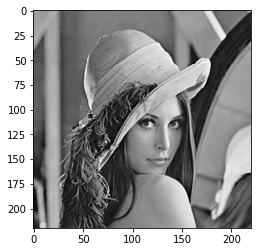

In [4]:
plt.imshow(imagen, cmap='gray')

#### Imagen binaria

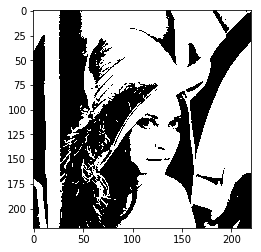

In [5]:
plt.imshow(otsu_imagen, cmap='gray')

## Contornos

In [6]:
imagen = cv2.imread('img/contornos.png', 0)

#### Encontrar contornos internos y externos, organizados en una jerarquía de dos niveles

In [7]:
contornos, jerarquia = cv2.findContours(imagen, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

#### Imagen Original

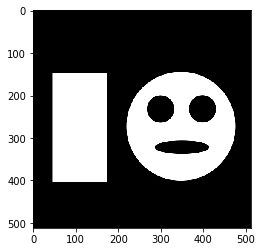

In [8]:
plt.imshow(imagen, cmap='gray')

#### Contornos externos

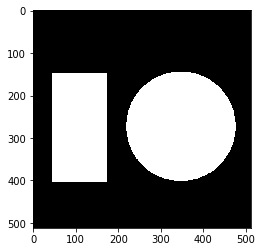

In [9]:
imagen_externos = np.zeros(imagen.shape, imagen.dtype)
for i in range(len(contornos)):
    if jerarquia[0][i][3] == -1:
        cv2.drawContours(imagen_externos, contornos, i, 255, -1)
plt.imshow(imagen_externos, cmap='gray')

#### Contornos internos

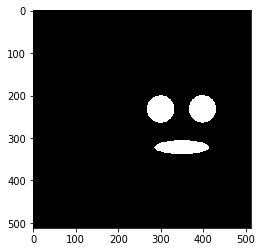

In [10]:
imagen_internos = np.zeros(imagen.shape, imagen.dtype)
for i in range(len(contornos)):
    if jerarquia[0][i][3] != -1:
        cv2.drawContours(imagen_internos, contornos, i, 255, -1)
plt.imshow(imagen_internos, cmap='gray')

## Extraer componentes conectados de una imagen binaria

Existen dos funciones en OpenCV que pueden utilizarse oara encontrar componentes conectados: `cv2.connectedComponents` y `cv2.connectedComponentsWithStats`. Ambas
toman el mismo número de argumentos:

* Imagen binaria
* Tipo de conectividad
* Profundidad de la imagen

`cv2.connectedComponents` es más simple y devuelve una tupla que contiene:

* Número de componentes
* Etiquetas para los componentes

`cv2.connectedComponentsWithStats` adicionalmente a lo anterior también devuelve:

* Estadíticas acerca del componente
* El centroide donde se localiza

In [11]:
imagen = cv2.imread('img/contornos.png', cv2.IMREAD_GRAYSCALE)

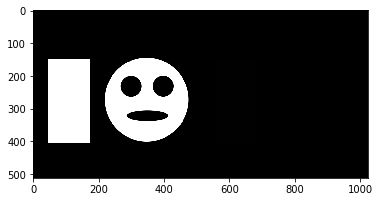

In [12]:
conectividad = 8
numero_etiquetas, mapa_etiquetas = cv2.connectedComponents(imagen, conectividad, cv2.CV_32S)
imagen_resultado = np.hstack((imagen, mapa_etiquetas.astype(np.float32)/(numero_etiquetas - 1)))
plt.imshow(imagen_resultado, cmap='gray')

### Extraer componentes conectados con base en las estadísticas de la imagen

In [13]:
imagen = cv2.imread('img/lena.png', cv2.IMREAD_GRAYSCALE)
otsu_umbral, otsu_imagen = cv2.threshold(imagen, -1, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
salida = cv2.connectedComponentsWithStats(otsu_imagen, conectividad, cv2.CV_32S)

#### Filtrar componentes en áreas pequeñas

In [14]:
numero_etiquetas, mapa_etiquetas, estadisticas, centros = salida
imagen_color = np.full((imagen.shape[0], imagen.shape[1], 3), 0, np.uint8)
for i in range(1, numero_etiquetas):
    if estadisticas[i][4] > 200:
        imagen_color[mapa_etiquetas == i] = (0, 255*i/numero_etiquetas, 255*numero_etiquetas/i)
        cv2.circle(imagen_color, (int(centros[i][0]), int(centros[i][1])), 4, (255, 0, 0), cv2.FILLED)

#### Imagen original

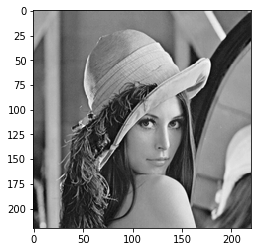

In [15]:
plt.imshow(imagen, cmap='gray')

#### Componentes conectados

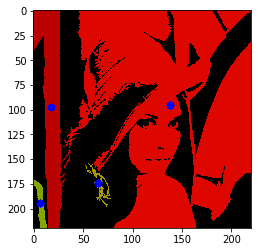

In [16]:
plt.imshow(imagen_color[:, :, [2, 1, 0]])    

## Aproximar líneas y círculos a partir de conjuntos de puntos

In [17]:
import random

#### Crear imagen para probar elipses

In [18]:
imagen = np.full((512, 512, 3), 255, np.uint8)
ejes = (int(256*random.uniform(0, 1)), int(256*random.uniform(0, 1)))
angulo = int(180*random.uniform(0, 1))
centro = (256, 256)

#### Generar puntos con los parámetros encontrados, añadiendo ruido

In [19]:
puntos = cv2.ellipse2Poly(centro, ejes, angulo, 0, 360, 1)
puntos += np.random.uniform(-10, 10, puntos.shape).astype(np.int32)

#### Dibujar elipse y los puntos generados

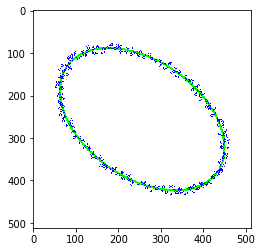

In [20]:
cv2.ellipse(imagen, centro, ejes, angulo, 0, 360, (0, 255, 0), 3)
for p in puntos:
    cv2.circle(imagen, (int(p[0]), int(p[1])), 3, (0, 0, 255))
plt.imshow(imagen)

#### Encontrar los parámetros de la elipse que mejor ajusta a los puntos

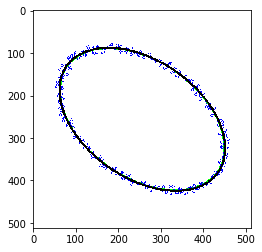

In [21]:
elipse = cv2.fitEllipse(puntos)
cv2.ellipse(imagen, elipse, (0, 0, 0), 3)
plt.imshow(imagen)

#### Crear imagen para probar línea *y=x*

In [22]:
imagen = np.full((512, 512, 3), 255, np.uint8)
puntos = np.arange(512).reshape(-1, 1)
puntos = np.hstack((puntos, puntos))
puntos += np.random.uniform(-10, 10, puntos.shape).astype(np.uint8)

#### Dibujar línea y puntos generados

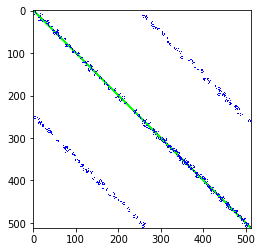

In [23]:
cv2.line(imagen, (0, 0), (512, 512), (0, 255, 0), 3)
for p in puntos:
    cv2.circle(imagen, (int(p[0]), int(p[1])), 3, (0, 0, 255))
plt.imshow(imagen)

#### Buscar recta que mejor ajuste a los puntos con ruido

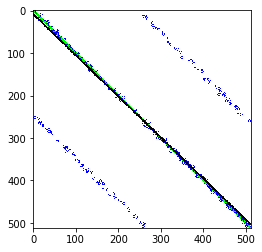

In [24]:
vx, vy, x, y = cv2.fitLine(puntos, cv2.DIST_L2, 0, 0.01, 0.01)
y0 = int(y - x*vy/vx)
y1 = int((512 - x)*vy/vx + y)
cv2.line(imagen, (0, y0), (512, y1), (0, 0, 0), 3)
plt.imshow(imagen)

## Calcular momentos

#### Imagen de prueba: elipse blanca con negro

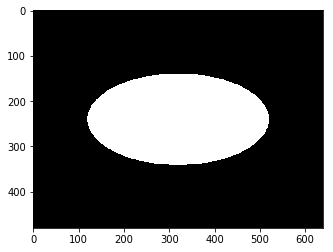

In [25]:
imagen = np.zeros((480, 640), np.uint8)
cv2.ellipse(imagen, (320, 240), (200, 100), 0, 0, 360, 255, -1)
plt.imshow(imagen, cmap='gray')

#### Calcular momentos y mostrar su valor

In [26]:
m = cv2.moments(imagen)
for nombre, valor, in m.items():
    print('{} {}'.format(nombre, valor))

m00 16119315.0
m10 5158101240.0
m01 3868620810.0
m20 1812142855350.0
m11 1237939564800.0
m02 969157708320.0
m30 683285449618080.0
m21 434912202354750.0
m12 310125260718570.0
m03 252129278267070.0
mu20 161575917357.31616
mu11 -72.9990234375
mu02 40692263506.42969
mu30 1687957749.125
mu21 -420182048.71875
mu12 -422443285.20703125
mu03 105694127.71875
nu20 0.0006218468887998859
nu11 -2.809466679966455e-13
nu02 0.00015660970937729079
nu30 1.618061841335058e-09
nu21 -4.0278291313762605e-10
nu12 -4.049505150683136e-10
nu03 1.013174855849065e-10


#### Calcular el centro de masa de la imagen usando el primer momento

In [27]:
print('Estimación centro X:', m['m10']/m['m00'])
print('Estimación centro Y:', m['m01']/m['m00'])

Estimación centro X: 319.9950643063927
Estimación centro Y: 239.999082467214


Se puede comprobar que es casi exacto, ya que debería ser igual al
centro de la elipse dibujada, en el punto *(320, 240)*

> Acerca de los momentos y su significado:
> https://en.wikipedia.org/wiki/Image_moment

## Curvas: aproximación, longitud y área

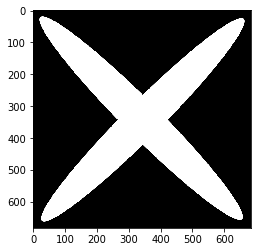

In [28]:
imagen = cv2.imread('img/cruz.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(imagen, cmap='gray')

#### Encontrar contornos y dibujarlos

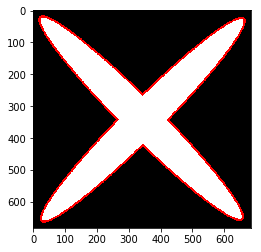

In [29]:
contornos, jerarquia = cv2.findContours(imagen, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
imagen_color = cv2.cvtColor(imagen, cv2.COLOR_GRAY2BGR)
cv2.drawContours(imagen_color, contornos, -1, (255, 0, 0), 5)
plt.imshow(imagen_color)

#### Definir callback para manejar clicks en la imagen. 

Dibuja una punto donde se produzca el click. El color será dependiente de la posición:

* Verde si es dentro de la figura
* Rojo si es fuera de la figura
* Morado si es sobre el contorno

Con texto se muestra la distancia del punto a la figura.

In [30]:
contorno = contornos[0]
imagen_muestra = np.copy(imagen_color)
medida = True

def callback_mouse(evento, x, y, banderas, parametros):
    global contorno, imagen_muestra
    if evento == cv2.EVENT_LBUTTONUP:
        distancia = cv2.pointPolygonTest(contorno, (x, y), medida)
        imagen_muestra = np.copy(imagen_color)
        if distancia > 0:
            color = (0, 255, 0)
        elif distancia < 0:
            color = (0, 0, 255)
        else:
            color = (128, 0, 128)
        cv2.circle(imagen_muestra, (x,y), 5, color, -1)
        cv2.putText(imagen_muestra, '%.2f' % distancia, (0, imagen_muestra.shape[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255))

#### Se muestra la imgaen y se utiliza la tecla *M* para cambiar de modo

In [31]:
cv2.namedWindow('Contornos')
cv2.setMouseCallback('Contornos', callback_mouse)
while True:
    cv2.imshow('Contornos', imagen_muestra)
    k = cv2.waitKey(1)
    if k == ord('m'):
        medida = not medida
    elif k == 27:
        break
        
cv2.destroyAllWindows()

## Calcular mapas de distancia

Los mapas de distancia se pueden calcular con la función `cv2.distanceTransform`.  Toma como parámetro el tipo de distancia
que se quiere calcular hacia el pixel más cercano de valor cero.

#### Imagen de prueba: círculo negro con fondo blanco

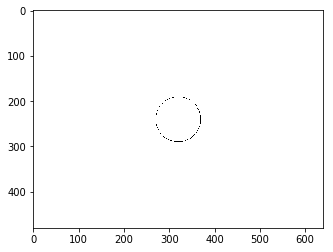

In [32]:
imagen = np.full((480, 640), 255, np.uint8)
cv2.circle(imagen, (320, 240), 50, 0)
plt.imshow(imagen, cmap='gray')

#### Calcular la distancia de cada punto hacia el círculo

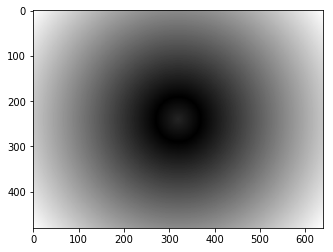

In [33]:
mapa_distancias = cv2.distanceTransform(imagen, cv2.DIST_L2, cv2.DIST_MASK_PRECISE)
plt.imshow(mapa_distancias, cmap='gray')

#### Añadiendo más circunferencias

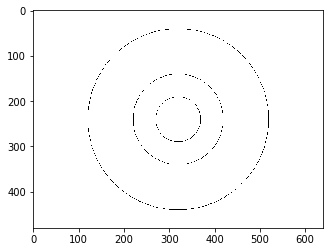

In [34]:
cv2.circle(imagen, (320, 240), 200, 0)
cv2.circle(imagen, (320, 240), 100, 0)
plt.imshow(imagen, cmap='gray')

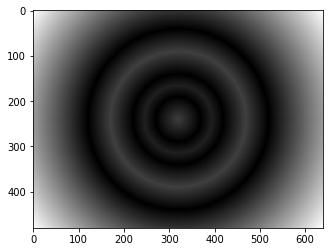

In [35]:
mapa_distancias = cv2.distanceTransform(imagen, cv2.DIST_L2, cv2.DIST_MASK_PRECISE)
plt.imshow(mapa_distancias, cmap='gray')

## Segmentación utilizando el algoritmo *K-means*

Para aplicar el algoritmo de agrupamiento K-means se utiliza la 
función `cv2.kmeans`. Ésta toma como parámetros:

* Datos de entrada
    
    Vector de puntos con valores reales.  


* Número de clusters

    Determina el número de cluster que se generarán. Entre más
    grande sea el valor, mayor número de clusters, pero más
    susceptible al ruido.


* Arreglo de entrada/salida con etiquetas (puede dejarse en `None`)
    
    Determina las posiciones iniciales de los clusters.


* Criterio de finalización
    
    Determina cuándo debe terminar el algoritmo.


* Número de intentos

    Determina cuántas veces se repetirá el algoritmo para poder
    alcanzar el objetivo.


* Banderas de control

    Determina el tipo de inicialización de los clusters:
    
    * `cv2.KMEANS_RANDOM_CENTERS`: los centros son generados de forma 
    aleatoria
       
    * `cv2.KMEANS_PP_CENTERS`: se utilizan técnicas más avanzadas para 
    determinar mejores centros.
    
    * `cv2.KMEANS_USE_INITIAL_LABELS`: utiliza el arreglo proporcionado como parámetro.

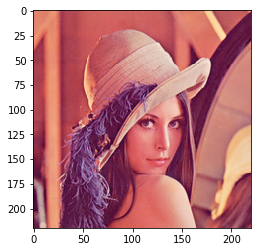

In [36]:
imagen = cv2.imread('img/lena.png').astype(np.float32) / 255
plt.imshow(imagen[:, :, [2,1,0]])

#### Convertir el espacio de color [lab](https://es.wikipedia.org/wiki/Espacio_de_color_Lab)

Se utiliza el espacio de color Lab debido a su propiedad de separar la
información de color de la información del brillo.

In [37]:
imagen_lab = cv2.cvtColor(imagen, cv2.COLOR_BGR2LAB)

#### Transformar de matriz a vector

In [38]:
datos = imagen_lab.reshape((-1, 3))

#### Definir parámetros del algoritmo y ejecutar

La función la devuelve distancia a su centro de cada pixel, un vector de etiquetas y un vector de valores. El vector de etiquetas tiene el mismo
tamaño que el vector de entrada, y representa el nombre del cluster al que
fue agrupado. El vector de valores contiene el valor del centroide para
cada etiqueta.

In [39]:
numero_clases = 4
criterio_finalizacion = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 50, 0.1)
_, etiquetas, centros = cv2.kmeans(datos, numero_clases, None, criterio_finalizacion, 10, cv2.KMEANS_RANDOM_CENTERS)

#### Aplicar el color del centroide al cluster completo y regresar a una matriz RGB

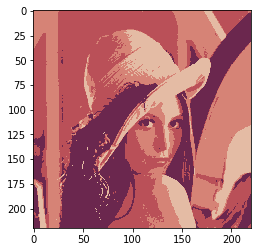

In [40]:
imagen_semgmentada_lab = centros[etiquetas.flatten()].reshape(imagen.shape)
imagen_segmentada = cv2.cvtColor(imagen_semgmentada_lab, cv2.COLOR_LAB2RGB)
plt.imshow(imagen_segmentada)

#### Aplicar menos clases

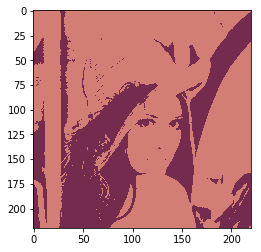

In [41]:
numero_clases = 2
criterio_finalizacion = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 50, 0.1)
_, etiquetas, centros = cv2.kmeans(datos, numero_clases, None, criterio_finalizacion, 10, cv2.KMEANS_RANDOM_CENTERS)
imagen_semgmentada_lab = centros[etiquetas.flatten()].reshape(imagen.shape)
imagen_segmentada = cv2.cvtColor(imagen_semgmentada_lab, cv2.COLOR_LAB2RGB)
plt.imshow(imagen_segmentada)

#### Aplicar más clases

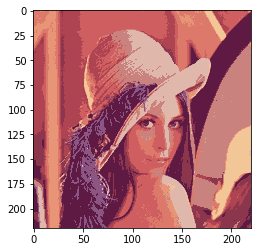

In [42]:
numero_clases = 10
criterio_finalizacion = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 50, 0.1)
_, etiquetas, centros = cv2.kmeans(datos, numero_clases, None, criterio_finalizacion, 10, cv2.KMEANS_RANDOM_CENTERS)
imagen_semgmentada_lab = centros[etiquetas.flatten()].reshape(imagen.shape)
imagen_segmentada = cv2.cvtColor(imagen_semgmentada_lab, cv2.COLOR_LAB2RGB)
plt.imshow(imagen_segmentada)

## Segmentación utilizando el algoritmo de Watershed

Este algoritmo se utiliza cuando se tienen puntos iniciales de 
segmentación y se quiere rellena un área con la misma clase a la que
pertence tal punto. Estos puntos son llamados semillas.

In [43]:
from random import randint

#### Cargar imagen, y crear otras para los resultados

In [44]:
imagen = cv2.imread('img/lena.png')
imagen_muestra = np.copy(imagen)
semillas = np.full(imagen.shape[0:2], 9, np.int32)
segmentacion = np.full(imagen.shape, 0, np.uint8)

#### Definir parámetros de algoritmo

In [45]:
numero_semillas = 9
colores = []
for c in range(numero_semillas):
    colores.append((255 * c / numero_semillas, randint(0, 255), randint(0, 255)))
mouse_presionado = False
semilla_actual = 1
actualizar_semillas = False

#### Implementar *callback* para manejar eventos del raton, que permite seleccionar las semillas

In [46]:
def callback_mouse(evento, x, y, banderas, parametros):
    global mouse_presionado, actualizar_semillas
    
    if evento == cv2.EVENT_LBUTTONDOWN:
        mouse_presionado = True
        cv2.circle(semillas, (x, y), 5, (semilla_actual), cv2.FILLED)
        cv2.circle(imagen_muestra, (x, y), 5, colores[semilla_actual - 1], cv2.FILLED)
        actualizar_semillas = True
    elif evento == cv2.EVENT_MOUSEMOVE:
        if mouse_presionado:
            cv2.circle(semillas, (x, y), 5, (semilla_actual), cv2.FILLED)
            cv2.circle(imagen_muestra, (x, y), 5, colores[semilla_actual - 1], cv2.FILLED)
            actualizar_semillas = True
    elif evento == cv2.EVENT_LBUTTONUP:
        mouse_presionado = False

#### Aplicar el algoritmo

Se debe dar *click*, en la imagen original, donde se quiera poner una 
semilla y en la otra ventana se visualizará la segmentación que se hará 
a partir de ese punto. El color de la segmentación será el mismo que el 
del punto, para poder cambiar el color de la semilla se debe presionar 
alguna tecla numérica del rango [1,9].

In [47]:
cv2.namedWindow('Imagen')
cv2.setMouseCallback('Imagen', callback_mouse)

while True:
    cv2.imshow('segmentacion', segmentacion)
    cv2.imshow('Imagen', imagen_muestra)
    k = cv2.waitKey(1)
    
    if k == 27:
        break
    elif k == ord('c'):
        imagen_muestra = np.copy(imagen)
        semillas = np.full(imagen.shape[0:2], 0, np.int32)
        segmentacion = np.full(imagen.shape, 0, np.int8)
    elif k > 0 and chr(k).isdigit():
        n = int(chr(k))
        if 1 <= n <= numero_semillas and not mouse_presionado:
            semilla_actual = n
    if actualizar_semillas and not mouse_presionado:
        copia_semillas = np.copy(semillas)
        cv2.watershed(imagen, copia_semillas)
        segmentacion = np.full(imagen.shape, 0, np.uint8)
        for m in range(numero_semillas):
            segmentacion[copia_semillas == (m + 1)] = colores[m]
        actualizar_semillas = False

cv2.destroyAllWindows()

In [48]:
cv2.destroyAllWindows()